In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rna-seq-data-analysis/GSE183947_fpkm.csv


In [4]:
!pip install scipy

In [5]:
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')

# Load Data

In [6]:
fpkm_path = "/kaggle/input/rna-seq-data-analysis/GSE183947_fpkm.csv"
df = pd.read_csv(fpkm_path)

# First column = gene symbol
gene_col = df.columns[0]
genes = df[gene_col]

# Next 60 columns = 30 normal (CA.*) + 30 tumor (CAP.*)
normal_cols = [c for c in df.columns[1:] if c.startswith("CA.")]
tumor_cols  = [c for c in df.columns[1:] if c.startswith("CAP.")]

print("Genes:", df.shape[0])
print("Normal samples:", len(normal_cols))
print("Tumor samples:", len(tumor_cols))

Genes: 20246
Normal samples: 30
Tumor samples: 30


# Differential Gene Expression Analysis
Because we have FPKM (not raw counts), we’ll use:
- log-transform: log2(FPKM + 1)
- Then run a Welch’s t-test per gene (tumor vs normal)
- correct p-values with Benjamini–Hochberg FDR

In [7]:
import scipy.stats as stats

# Log2 transform
mat = df[normal_cols + tumor_cols].astype(float)
log2mat = np.log2(mat + 1.0)

normal_mat = log2mat[normal_cols]
tumor_mat  = log2mat[tumor_cols]

pvals = []
log2fc = []   # tumor vs normal

for i in range(log2mat.shape[0]):
    n = normal_mat.iloc[i].values
    t = tumor_mat.iloc[i].values
    stat, p = stats.ttest_ind(t, n, equal_var=False, nan_policy='omit')
    pvals.append(p)
    log2fc.append(t.mean() - n.mean())

pvals = np.array(pvals)

In [8]:
# Benjamini–Hochberg FDR
mask = ~np.isnan(pvals)
p = pvals[mask]
m = len(p)

order = np.argsort(p)
rank = np.empty_like(order)
rank[order] = np.arange(1, m+1)
fdr = p * m / rank
# enforce monotonicity
fdr_sorted = np.minimum.accumulate(np.sort(fdr)[::-1])[::-1]
fdr_final  = np.empty_like(p)
fdr_final[order] = fdr_sorted

FDR_all = np.full_like(pvals, np.nan, dtype=float)
FDR_all[mask] = fdr_final

res = pd.DataFrame({
    "gene": genes,
    "log2FC_tumor_vs_normal": log2fc,
    "pvalue": pvals,
    "FDR": FDR_all
})

In [9]:
# Saving results
res.to_csv("GSE183947_DE_results.csv", index=False)

In [10]:
# significantly DE genes
sig = res[(res["FDR"] < 0.05) & (res["log2FC_tumor_vs_normal"].abs() > 1)]
print("Significant DE genes:", sig.shape[0])
print(sig.sort_values("log2FC_tumor_vs_normal", ascending=False).head())

Significant DE genes: 1796
          gene  log2FC_tumor_vs_normal        pvalue           FDR
18702  DEFB130                3.941893  2.178467e-22  2.189142e-18
19468    LIMS3                3.538422  2.773603e-14  2.654470e-11
17420     LCN6                3.531396  1.463142e-19  4.901039e-16
19413  CCDC177                3.530750  4.056647e-29  8.153050e-25
17982     KLK9                3.420770  4.732819e-22  3.059619e-18


# Volcano plot and MA plot

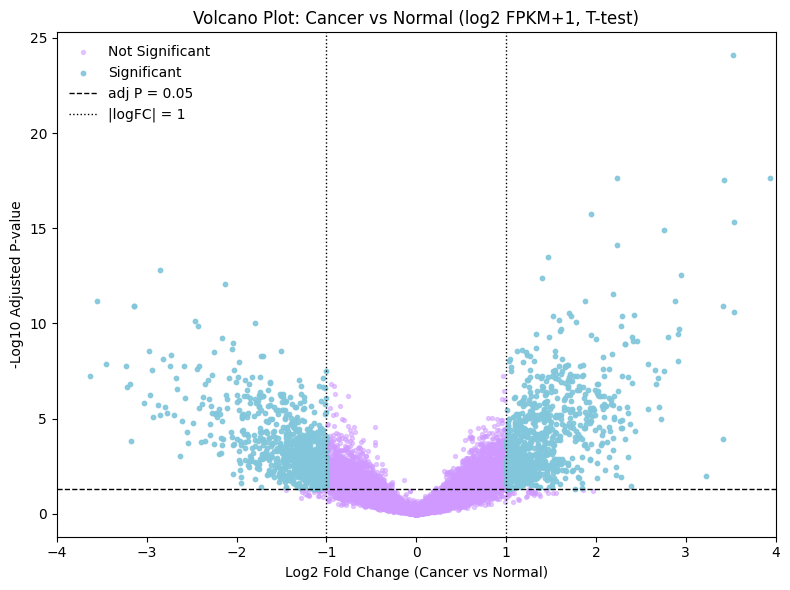

In [29]:
res_nonan = res.dropna(subset=["FDR", "pvalue"]).copy()

fc  = res_nonan["log2FC_tumor_vs_normal"]
fdr = res_nonan["FDR"]

# thresholds
fc_thr = 1.0
fdr_thr = 0.05
y_thr = -np.log10(fdr_thr)

# classify
sig_mask    = (fdr < fdr_thr) & (fc.abs() > fc_thr)
nonsig_mask = ~sig_mask

# soft colors
col_nonsig = "#cf99ff"   # light lavender
col_sig    = "#81c6db"   # soft blue

plt.figure(figsize=(8, 6))

# non-significant
plt.scatter(
    fc[nonsig_mask],
    -np.log10(fdr[nonsig_mask]),
    s=8,
    alpha=0.5,
    color=col_nonsig,
    label="Not Significant"
)

# significant
plt.scatter(
    fc[sig_mask],
    -np.log10(fdr[sig_mask]),
    s=10,
    alpha=0.9,
    color=col_sig,
    label="Significant"
)

# horizontal line for adj p = 0.05
plt.axhline(y_thr, color="black", linestyle="--", linewidth=1, label="adj P = 0.05")

# vertical lines for |logFC| = 1
plt.axvline(fc_thr,  color="black", linestyle=":", linewidth=1, label="|logFC| = 1")
plt.axvline(-fc_thr, color="black", linestyle=":", linewidth=1)

plt.xlabel("Log2 Fold Change (Cancer vs Normal)")
plt.ylabel("-Log10 Adjusted P-value")
plt.title("Volcano Plot: Cancer vs Normal (log2 FPKM+1, T-test)")
plt.xlim(-4, 4)   # optional, to match example
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


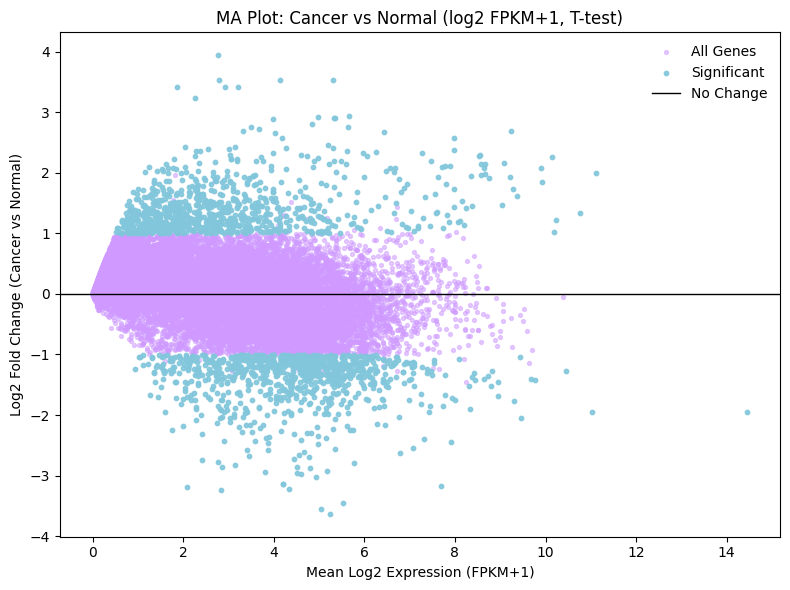

In [31]:
# build MA dataframe
mean_expr = (normal_mat.mean(axis=1) + tumor_mat.mean(axis=1)) / 2.0
ma_df = pd.DataFrame({
    "A": mean_expr.values,
    "M": res["log2FC_tumor_vs_normal"].values,
    "FDR": res["FDR"].values
}).dropna(subset=["FDR"])

fc_thr = 1.0
fdr_thr = 0.05

sig_mask_ma = (ma_df["FDR"] < fdr_thr) & (ma_df["M"].abs() > fc_thr)
nonsig_mask_ma = ~sig_mask_ma

col_all = "#cf99ff"   # light lavender
col_sig = "#81c6db"   # soft blue

plt.figure(figsize=(8, 6))

# all (non-significant) genes
plt.scatter(
    ma_df.loc[nonsig_mask_ma, "A"],
    ma_df.loc[nonsig_mask_ma, "M"],
    s=8,
    alpha=0.5,
    color=col_all,
    label="All Genes"
)

# significant genes
plt.scatter(
    ma_df.loc[sig_mask_ma, "A"],
    ma_df.loc[sig_mask_ma, "M"],
    s=10,
    alpha=0.9,
    color=col_sig,
    label="Significant"
)

# no-change line (M=0)
plt.axhline(0, color="black", linewidth=1, label="No Change")

plt.xlabel("Mean Log2 Expression (FPKM+1)")
plt.ylabel("Log2 Fold Change (Cancer vs Normal)")
plt.title("MA Plot: Cancer vs Normal (log2 FPKM+1, T-test)")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

# Downstream analysis

## Exporting gene list

In [13]:
# Upregulated genes (tumor > normal)
up = sig[sig["log2FC_tumor_vs_normal"] > 0]["gene"]
up.to_csv("DEG_up_genes.txt", index=False, header=False)

# Downregulated genes
down = sig[sig["log2FC_tumor_vs_normal"] < 0]["gene"]
down.to_csv("DEG_down_genes.txt", index=False, header=False)

# g:Profiler

In [14]:
!pip install gprofiler-official

In [17]:
from gprofiler import GProfiler

# 2) Preparing gene list (from your DE result)
up_genes = sig[sig["log2FC_tumor_vs_normal"] > 0]["gene"].dropna().tolist()

gp = GProfiler(return_dataframe=True)

# 3) Run enrichment
enrich_res = gp.profile(
    organism='hsapiens',
    query=up_genes,
    sources=['GO:BP', 'KEGG']  # biological process + KEGG pathways
)

# Seeing top hits
enrich_res.head()

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
0,GO:BP,GO:0048513,animal organ development,1.427902e-39,True,"""Development of a tissue or tissues that work ...",3085,731,253,21026,0.346101,0.082010,query_1,[GO:0048856]
1,GO:BP,GO:0048856,anatomical structure development,7.425975e-37,True,"""The biological process whose specific outcome...",5997,731,376,21026,0.514364,0.062698,query_1,[GO:0032502]
2,GO:BP,GO:0032501,multicellular organismal process,6.060319e-35,True,"""Any biological process, occurring at the leve...",7322,731,423,21026,0.578659,0.057771,query_1,[GO:0008150]
3,GO:BP,GO:0032502,developmental process,2.058133e-33,True,"""A biological process whose specific outcome i...",6553,731,390,21026,0.533516,0.059515,query_1,[GO:0008150]
4,GO:BP,GO:0048731,system development,1.489542e-29,True,"""The process whose specific outcome is the pro...",4053,731,277,21026,0.378933,0.068344,query_1,"[GO:0007275, GO:0048856]"


In [18]:
enrich_res.to_csv("GSE183947_up_enrichment_gprofiler.csv", index=False)